# Reverse Annealing
This notebook explores D-Wave's [reverse anneal feature](#Understanding-Reverse-Anneal). This feature can improve solutions to a problem and provide insight into the behavior and dynamics of problems undergoing quantum annealing.

1. [The Reverse Anneal Feature](#The-Reverse-Anneal-Feature) explains the feature and its parameters.
2. [Using the Reverse Anneal Feature](#Using-the-Reverse-Anneal-Feature) demonstrates the use of the feature on a random example problem.
3. [Analysis on a 16-Bit Problem](#Analysis-on-a-16-Bit-Problem) uses reverse annealing on a known problem and compares the results with other anneal methods.
4. [Modulating the Reverse-Annealing Parameters](#Modulating-the-Reverse-Annealing-Parameters) provides code that lets you sweep through various anneal schedules to explore the effect on results.

A brief white paper describing the reverse annealing feature can be found [here](https://www.dwavesys.com/media/5hsjmvom/14-1018a-a_reverse_quantum_annealing_for_local_refinement_of_solutions.pdf).

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# The Reverse Anneal Feature

The [Getting Started with the D-Wave System](https://docs.dwavesys.com/docs/latest/doc_getting_started.html) document describes quantum annealing and the [Solver Properties and Parameters](https://docs.dwavesys.com/docs/latest/doc_solver_ref.html) book describes the parameters used here.

In brief, reverse annealing is a technique that makes it possible to refine known good local solutions, thereby increasing performance for certain applications. It comprises (1) annealing backward from a known classical state to a mid-anneal state of quantum superposition, (2) searching for optimum solutions at this mid-anneal point while in the presence of an increased transverse field (quantum state), and then (3) proceeding forward to a new classical state at the end of the anneal.

There are three parameters you can use to configure reverse annealing using Ocean:

1. `anneal_schedule` defines the annealing schedule that should be followed.
2. `initial_state` specifies the classical state at which the reverse anneal should start.
3. `reinitialize_state` specifies whether or not the initial state should be used for every anneal in the request.  If False, then after the first, each subsequent anneal starts where the previous finished.

## Reinitializing the Initial State

The `reinitialize_state` parameter switches between two qualitatively different methods of local search via quantum annealing.  With `reinitialize_state = 'True'`, many anneals are seeded from the single starting state and the states returned, modulo time-dependent sources of error, are independently and identically distributed.  With `reinitialize_state = 'False'`, the series of anneals behaves like a random walk and is capable of exploring the solution space more broadly.  

Section [Using the Reverse Anneal Feature](#Using-the-Reverse-Anneal-Feature) demonstrates one method while Section [Analysis on a 16-Bit Problem](#Analysis-on-a-16-Bit-Problem) demonstrates the other.

## Feature Availability

Availability of the reverse anneal feature depends on the solver you connect to. This subsection checks whether your solver supports this feature by querying solver property `max_anneal_schedule_points`  and ensuring it is at least 4---see the [Solver Properties and Parameters](https://docs.dwavesys.com/docs/latest/doc_solver_ref.html) book for a description of the anneal schedule and the requirements for supporting this feature. 

The first cell below sets up a connection to the quantum processing unit (QPU). The second cell checks the number of anneal-schedule points supported and also checks the annealing time range (in μs) and maximum slope (slopes of each line segment of an anneal schedule must not violate the maximum slope).

Your code can ensure that any solver it connects to supports the feature by making it a selection criterion: `sampler = DWaveSampler(solver=dict(max_anneal_schedule_points__gte=4))` selects only a solver that supports at least 4 anneal-schedule points.

In [1]:
from dwave.system.samplers import DWaveSampler

sampler = DWaveSampler()   

print("Connected to sampler", sampler.solver.name)

Connected to sampler Advantage_system4.1


In [2]:
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))

max_slope = 1.0/sampler.properties["annealing_time_range"][0]

print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))

Maximum anneal-schedule points: 12
Annealing time range: [0.5, 2000.0]
Maximum slope allowed on this solver is 2.00.


# Using the Reverse Anneal Feature

This section demonstrates the use of the feature, comparing samples returned from forward and reverse annealing on a random problem.

This section configures `reinitialize_state = False`.

## Generating a Random Problem
For simplicity, the problem chosen in this section is a random +/- 1 input on the solver's working graph. It is sufficient to demonstrate the feature.

The next cell formulates the problem for the D-Wave system (configures values of the linear and quadratic coefficients, $h_i$ and $J_{i,j}$, used to program the system).

In [7]:
import numpy as np

h = {v: 0.0 for v in sampler.nodelist}
J = {tuple(c): np.random.choice([-1, 1]) for c in sampler.edgelist}

print("Bias 0 assigned to", len(h), "qubits.")
print("Strengths -1/+1 assigned randomly to",len(J),"couplers.")

Bias 0 assigned to 5627 qubits.
Strengths -1/+1 assigned randomly to 40279 couplers.


## Defining the Anneal Schedule
This subsection sets and displays an example annealing schedule. The following sections will help you understand the choice of parameters used here; for now consider that it should reverse enough to allow for exploration without in effect becoming a standard forward anneal.    

The chosen schedule starts at `s = 1.0`, reverses quickly to `s = 0.45`, pauses for 80 μs, then quickly anneals forward. The schedule is formatted as a list of  **[time, s]** pairs. The next cell plots the schedule.

Note that when providing the `anneal_schedule` parameter, you do not provide the `annealing_time` parameter because this information is contained in the schedule.

In [8]:
from helpers.schedule import make_reverse_anneal_schedule # To see helper functions, select Jupyter File Explorer View from the Online Learning page

reverse_schedule = make_reverse_anneal_schedule(s_target=0.45, hold_time=80, ramp_up_slope=max_slope)
time_total = reverse_schedule[3][0]

print(reverse_schedule)
print("Total anneal-schedule time is {} us".format(time_total))

[[0.0, 1.0], [2.75, 0.45], [82.75, 0.45], [83.025, 1.0]]
Total anneal-schedule time is 83.025 us


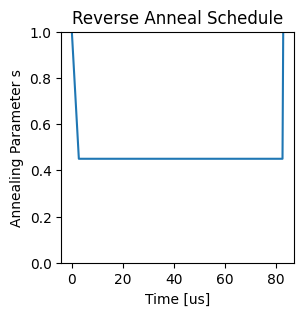

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(1, figsize=(3, 3))
plt.plot(*np.array(reverse_schedule).T)
plt.title("Reverse Anneal Schedule")
plt.xlabel("Time [us]")
plt.ylabel("Annealing Parameter s")
plt.ylim([0.0,1.0])
plt.show()

## Setting the Initial State

The next cell sets the state that reverse anneal starts from. It runs a standard forward anneal on the problem and then selects a sample 5% indexically distant from the lowest-energy solution. For most executions, this sample has higher energy and represents a lower-quality solution. 

Note that it may be convenient but it is not necessary to use forward annealing to provide an initial state. You can also provide a known solution or even a random sample. 

In [10]:
forward_answer = sampler.sample_ising(h, J, 
                                      num_reads=1000, 
                                      annealing_time=time_total, 
                                      label='Notebook - Reverse Annealing',
                                      answer_mode='histogram')
forward_solutions, forward_energies = forward_answer.record.sample, forward_answer.record.energy
i5 = int(5.0/95*len(forward_answer))  # Index i5 is about a 5% indexial move from the sample of lowest energy

initial = dict(zip(forward_answer.variables, forward_answer.record[i5].sample))

print("Lowest energy found: {}".format(forward_answer.record.energy[0]))
print("Average energy is {:.2f} with standard deviation {:.2f}".format(forward_energies.mean(), forward_energies.std()))
print("\nSetting the initial state to a sample with energy: {}".format(forward_answer.record.energy[i5]))

Lowest energy found: -15737.0
Average energy is -15686.23 with standard deviation 19.02

Setting the initial state to a sample with energy: -15715.0


## Running Reverse Anneal
This cell makes a QPU call for reverse annealed samples. As noted previously, this section uses `reinitialize_state=False`.

In [11]:
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=False)
reverse_answer = sampler.sample_ising(h, J, 
                                      num_reads=1000, 
                                      label='Notebook - Reverse Annealing',
                                      answer_mode='histogram', 
                                      **reverse_anneal_params)
reverse_solutions, reverse_energies = reverse_answer.record.sample, reverse_answer.record.energy

print("Lowest energy found:", reverse_answer.record.energy[0])
print("Average energy is {:.2f} with standard deviation {:.2f}".format(reverse_energies.mean(), reverse_energies.std()))

Lowest energy found: -15729.0
Average energy is -15717.92 with standard deviation 4.62


In most cases, the energy of samples from reverse annealing has lower variance than for forward annealing; this is because the quantum annealing search occurs in a sub-region of the solution space. Typical executions of this cell return at least a lower average energy, if not the lowest energy; that is, the samples are clustered at the lower-energy end of the solution space searched by the forward anneal.  

# Analysis on a 16-Bit Problem
This section demonstrates on an example problem how the reverse anneal feature can improve solutions  compared to standard forward annealing and forward annealing with a pause. It configures `reinitialize_state=True`.

The example problem is the 16-qubit system shown below, which was studied in https://www.nature.com/articles/ncomms2920, and has an energy gap  of 4 between the classical ground state and excited states.
This system is set up as shown in the image below, where dots are qubits with colors representing bias values and lines representing couplings (couplings weights are $-1$).
 
<img src='images/16q_system.png'>

## Generating the 16-Bit Problem
The structure of this problem maps neatly to the Chimera topology of a D-Wave 2000Q QPU: it can be minor-embedded directly into two side-by-side Chimera unit cells, with each problem qubit represented by one qubit on the QPU. On Advantage systems, the problem can be similarly represented by qubits in two of the Chimera unit cell's near-counterpart structure in the Pegasus topology: $K_{4,4}$ bicliques with additional *odd* couplers.

If you were to use a standard heuristic embedder such as [minorminer](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html), however, some of the problem qubits might be represented by chains of qubits on the QPU. Instead, qubits of two ideal Chimera unit cells are used directly in the `h` and `J` definitions below and the `TilingComposite` composite scans adjacent unit cells on the QPU, finds adjacent pairs in which all the required qubits and couplers are available, and translates the one-to-one minor-embedding of the problem from the first two adjacent pairs to the first available valid pairs.

In [12]:
h = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
     8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
J = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
     (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
     (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
     (2, 5): -1, (2, 4): -1, (6, 14): -1}

In [23]:
sampler.solver.name

'Advantage_system4.1'

In [13]:
from dwave.system import TilingComposite, FixedEmbeddingComposite

tiled_sampler = TilingComposite(sampler, 1, 2, 4)

if tiled_sampler.num_tiles:
    sampler_embedded = FixedEmbeddingComposite(sampler, embedding=tiled_sampler.embeddings[0])
else:
    print("Unable to find two complete unit cells in QPU {}".format(sampler.solver.name))

The next cell prints the energies for the global minimum solution and an arbitrary sample.  

In [14]:
from dimod import ising_energy
import random

ground_state = {s_i:-1 for s_i in range(16)} # Global minimum is for all qubits with spin value -1  
ground_energy = ising_energy(ground_state, h, J)

print("Energy of the global minimum: {}".format(ground_energy))
print("Energy of a random sample: {}".format(ising_energy({s_i: 2*random.randint(0, 1)-1 for s_i in range(16)}, h, J)))

Energy of the global minimum: -20.0
Energy of a random sample: 6.0


## Sampling Methods and Configuration
The next subsections compare the following sampling methods:

* Standard forward annealing
* Forward annealing with a pause
* Reverse annealing with `reinitialize_state=True`

The cell below configures some shared parameters; the next cells configure parameters used by the different methods.

In [15]:
reads = 1000

### Pause Schedule
The next cell sets and plots the schedule for forward anneal with pause.

In [25]:
print(pause_schedule)

[[0.0, 0.0], [50.0, 0.5], [82.775, 0.5], [83.025, 1.0]]


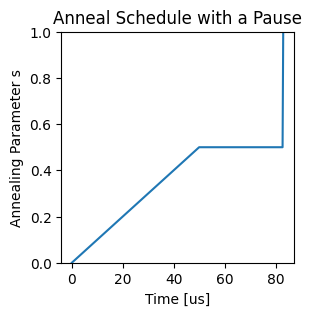

In [16]:
pause_schedule=[[0.0, 0.0], [50.0, 0.5], [time_total-0.5/max_slope, 0.5], [time_total, 1.0]]

plt.figure(1, figsize=(3, 3))
plt.plot(*np.array(pause_schedule).T)
plt.title("Anneal Schedule with a Pause")
plt.xlabel("Time [us]")
plt.ylabel("Annealing Parameter s")
plt.ylim([0.0,1.0])
plt.show()

### Initial State for Reverse Anneal 
The next cell sets the initial state for this example: a solution 6 bit-flips distance away from the global minimum solution of the 16-bit problem. 

In [17]:
def flip_bits(sample, spin_bits):
    sample.update({bit: -sample[bit] for bit in spin_bits})
    return sample

initial = flip_bits(dict(ground_state), {1, 4, 7, 10, 12, 15})
print("Energy of initial state: {}".format(ising_energy(initial, h, J)))

Energy of initial state: -4.0


## Defining Metrics
The following metrics are used in this section to analyze the quality of returned samples.

### Global-Minimum Ratio 
As a simple criterion for solution quality, this example uses the ratio of samples that represent the global minimum of the problem to higher-energy samples, with a higher ratio (the global minimum is found more often) being better. 

### Hamming Distance

Hamming distance is used as a measure of how tightly samples are grouped together. The Hamming distance of two samples counts the number of qubits with different values. A higher variance in this metric usually corresponds to an exploration of a greater search space for the anneals.

The function defined in the next cell calculates the Hamming distance between consecutive solutions and is used to visualize how closely grouped together samples are for each QPU call.

In [18]:
get_hamming_distance = lambda x1, x2: np.sum(x1 != x2)

def get_hamming_distances(sols):
    sols = np.array(sols)
    return np.array([get_hamming_distance(x1, x2) for x1, x2 in zip(sols, sols[1:])])

## Sampling
This subsection runs the three annealing methods on the 16-bit problem.  

The first cell defines a helper function to store and analyze the returned samples.

In [19]:
def analyze(answer):
    solutions, energies = answer.record.sample, answer.record.energy
    energy_best = round(answer.first.energy, 2)
    ratio = list(answer.record.energy).count(ground_energy)/float(reads)     
    hamming_distances = get_hamming_distances(solutions)
    energy_mean = round(energies.mean(), 2)
    hamming_mean = round(hamming_distances.mean(), 2)
    return([solutions, energies, hamming_distances, energy_best, ratio, energy_mean, hamming_mean])

The next cell submits the problem with each annealing method to the QPU, storing the returned samples with some statistics in a shared list.

In [20]:
data=[]

# Standard forward annealing
answer = sampler_embedded.sample_ising(h, J, 
                                       num_reads=reads, 
                                       annealing_time=time_total, 
                                       label='Notebook - Reverse Annealing',
                                       answer_mode='raw')
print("Obtained {} samples from standard forward annealing".format(len(answer)))
data.append(analyze(answer))

# Forward annealing with pause
answer = sampler_embedded.sample_ising(h, J, 
                                       anneal_schedule=pause_schedule, 
                                       num_reads=reads, 
                                       label='Notebook - Reverse Annealing',
                                       answer_mode='raw')
print("Obtained {} samples from forward annealing with a pause".format(len(answer)))
data.append(analyze(answer))

# Reverse annealing
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=True)
answer = sampler_embedded.sample_ising(h, J, 
                                       num_reads=reads, 
                                       label='Notebook - Reverse Annealing',
                                       answer_mode='raw', 
                                       **reverse_anneal_params)
print("Obtained {} samples from reverse annealing".format(len(answer)))
data.append(analyze(answer))

Obtained 1000 samples from standard forward annealing
Obtained 1000 samples from forward annealing with a pause
Obtained 1000 samples from reverse annealing


In [21]:
print(J)

{(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1, (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1, (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1, (2, 5): -1, (2, 4): -1, (6, 14): -1}


## Analysis
This subsection compares the results from the three annealing methods.

The cell below incorporates the samples and some analysis results into a pandas DataFrame for simple manipulation.

In [ ]:
import pandas as pd
df_columns, df_rows=["Solutions", "Energy", "Hamming Distance","Energy (Lowest)", "Global-Minimum Ratio", "Energy (Average)", "Hamming (Average)"], ["Forward", "Pause", "Reverse"]
df = pd.DataFrame(data,index=df_rows, columns=df_columns)

The next cell compares the ratio of samples that are the global minimum for the problem to all the samples. Usually the results for reverse annealing show a much higher ratio using the configured parameters for this problem. In the next section, you will see how to tune these parameters for a problem.  

In [ ]:
print("Lowest energy found for each method:\n")
print(df.loc[:,'Energy (Lowest)'])
print("\n\nRatio of global minimum to all samples:\n")
print(df.loc[:,'Global-Minimum Ratio'])

The next cell plots the energy and Hamming distances of consecutive samples, with averages drawn as a red line.

For most executions, samples from reverse annealing are more tightly clustered around the global minimum than those from forward annealing; this is because the quantum annealing search occurs in the lower-energy end of the solution space explored by forward annealing. 

In [ ]:
from helpers.plot import e_h_plot # To see helper functions, select Jupyter File Explorer View from the Online Learning page
e_h_plot(df)

# Modulating the Reverse-Annealing Parameters

Two straightforward ways to modulate the local search performed in reverse annealing are to change the start and duration of the pause in the annealing schedule. These are controlled by the `s_target` and `hold_time` arguments of the `make_reverse_anneal_schedule` function imported above.

(Another parameter of the `make_reverse_anneal_schedule` function is `ramp_up_slope`, which in this notebook has been set to the maximum value allowed on the QPU. A less steep slope is more similar to following the pause with a forward anneal whereas a steep slope is similar to a "quench", which abruptly terminates the anneal. Quench resembles a projective readout when the dynamics of the system are slow relative to the timescale of the quench. Using the maximum slope when the local search of a paused schedule is in the right vicinity increases the probability of obtaining the ground state.)

A lower value of `s_target` implies a larger transverse field, which leads to a broader search of the solution space.  A greater value of `hold_time` means that the reverse anneal is given more time to explore, which leads to a broader and deeper search of the solution space.  This subsection tries different combinations of these parameters and demonstrates the effect they have by plotting the distribution of energies and Hamming distance between consecutive reads.

In [ ]:
import itertools
import seaborn 
seaborn.set_style('whitegrid')

s_target_vals = [0.3, 0.45, 0.6, 0.75, 0.9]
hold_time_vals = [10, 100]
initial = flip_bits(dict(ground_state), {0, 7, 15})  # 3-bit Hamming distance from the global minimum

data_rows = list()
QPU_time=0.0
for s_target, hold_time in itertools.product(s_target_vals, hold_time_vals):
    
    print("Running reverse anneals with s_target={} and hold_time={} us".format(s_target, hold_time))
    schedule = make_reverse_anneal_schedule(s_target=s_target, hold_time=hold_time, ramp_up_slope=max_slope)
    reverse_anneal_params = dict(anneal_schedule=schedule, initial_state=initial, reinitialize_state=True)
    modulating_answer = sampler_embedded.sample_ising(h, J, 
                                                      num_reads=1000, 
                                                      label='Notebook - Reverse Annealing',
                                                      answer_mode='raw', 
                                                      **reverse_anneal_params)
    QPU_time+=modulating_answer.info['timing']['qpu_access_time']
    modulating_solutions, modulating_energies = modulating_answer.record.sample, modulating_answer.record.energy
    modulating_distances = get_hamming_distances(modulating_solutions)
    row = dict(
        s_target=s_target,
        hold_time=hold_time,
        energy_stdev=np.std(modulating_energies),
        energy_mean=np.mean(modulating_energies),
        distance_mean=np.mean(modulating_distances),
    )
    data_rows.append(row)

df = pd.DataFrame(data_rows)
print("QPU calls complete using", QPU_time/1000000.0, "seconds of QPU time.")

The next cell plots the results. 

In [ ]:
df_long = pd.melt(df, id_vars=['s_target', 'hold_time'])
g = seaborn.FacetGrid(df_long, hue='hold_time', col='variable', sharey=False, legend_out=True)
g.map(plt.plot, 's_target', 'value')
g.add_legend()
plt.suptitle("Statistics for Varying Reverse Annealing Parameters")
plt.subplots_adjust(left=.1, right=.9, top=.8)

These plots are not enough for conclusive statistics, but give an intuitive understanding of the feature. Seeing how the output of reverse annealing changes as a function of the parameters is a useful step in advanced analysis of an input. For example, there is typically a critical region of interest for the `s_target` parameter that can be identified using exploratory parameter sweeps.

The image below shows, for the 16-bit problem, using several initial solutions at varying Hamming distance from the global minimum, the ratio of global-minimum solutions to all returned samples from scanning through combinations of reverse-anneal parameters. Two hold times are plotted in different colors. 

<img src='images/16q_reverse_anneal.png'>

## Exercise: Reverse Anneal for Various Parameters
Modify the code below to run reverse anneal on the 16-bit problem with various parameters and develop a sense of where the "sweet spot" is for different initial solutions. 

The code is written for easy modification. Alternatively, you can modify the code above to scan through all the combinations and plot the results.

In [ ]:
# Select an initial solution by Hamming distance from the gloabl minimum
# 1-bit Hamming distance: initial = flip_bits(dict(ground_state), {15})
# 3-bit Hamming distance: initial = flip_bits(dict(ground_state), {0, 7, 15})
# 6-bit Hamming distance: initial = flip_bits(dict(ground_state), {1, 4, 7, 10, 12, 15})
# 9-bit Hamming distance: 
initial = flip_bits(dict(ground_state), {1, 2, 5, 6, 9, 10, 13, 14, 15})
# 13-bit Hamming distance: flip_bits(flip_bits(dict(ground_state), list(range(16))), {0, 7, 15})
# 16-bit Hamming distance: initial = flip_bits(dict(ground_state), list(range(16)))

# You can optionally modify the range of parameters
s_target_vals = [0.95, 0.85, 0.75, 0.65, 0.55, 0.45, 0.35]
hold_time_vals = [40, 100]

# x, y are indices to the s_target_vals, hold_time_vals lists, with 0, 0 selecting the first values
x, y = 5, 0
s_target, hold_time=s_target_vals[x], hold_time_vals[y]
schedule = make_reverse_anneal_schedule(s_target, hold_time, ramp_up_slope=max_slope)

# Plot the configured schedule
print(schedule)
plt.plot(*np.array(schedule).T)
plt.title("Anneal Schedule")
plt.xlabel("Time [us]")
plt.ylabel("Annealing Parameter s")
plt.ylim([0.0,1.0])
plt.show()

# Submit to the QPU and print results
reverse_anneal_params = dict(anneal_schedule=schedule, initial_state=initial, reinitialize_state=True)
reverse_answer = sampler_embedded.sample_ising(h, J, 
                                               num_reads=1000, 
                                               label='Notebook - Reverse Annealing',
                                               answer_mode='histogram', 
                                               **reverse_anneal_params)
print("s_target = {} and hold_time = {} us".format(s_target, hold_time))
print("Solution = {} and Energy = {}".format(reverse_answer.record.sample[0], reverse_answer.record.energy[0])) 
ratio = 0
if reverse_answer.record.energy[0] == ground_energy:
    ratio = reverse_answer.record[0]['num_occurrences']/float(reads)
print("Ratio of global minimum to other samples is {}".format(ratio))

Copyright &copy; 2021 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>